# Google - Isolated Sign Language Recognition

In [1]:
# Machine Learning and Data Science Imports (basics)
import tensorflow as tf
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import os
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
from PIL import Image, ImageEnhance; Image.MAX_IMAGE_PIXELS = 5_000_000_000;
from matplotlib import animation, rc; rc('animation', html='jshtml')
import json
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import plotly.io as pio
pio.templates.default = "simple_white"
import math

def seed_it_all(seed=42):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

from feature_engineering import *
from helper_functions import *

In [2]:
# import data from specified data directory
def load_json_file(json_path):
    with open(json_path, 'r') as f:
        sign_map = json.load(f)
    return sign_map

class CFG:
    data_dir = "/kaggle/input/asl-signs/"
    sequence_length = 12
    rows_per_frame = 543
    batch_size = 512

ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)
    
sign_map = load_json_file(CFG.data_dir + 'sign_to_prediction_index_map.json')
train_data = pd.read_csv(CFG.data_dir + 'train.csv')

s2p_map = {k.lower():v for k,v in load_json_file(CFG.data_dir + "sign_to_prediction_index_map.json").items()}
p2s_map = {v:k for k,v in load_json_file(CFG.data_dir + "sign_to_prediction_index_map.json").items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)

# inspect data from one parquet file
train_data.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [3]:
# Visualization of one parquet file
parquet_df = pd.read_parquet(CFG.data_dir + train_data.path[0])
visualise_landmarks(parquet_df).show()

## Model Pipeline

In [4]:
from sklearn.preprocessing import normalize
train_x = np.load("/kaggle/input/gislr-feature-data/feature_data.npy").astype(np.float32)
train_y = np.load("/kaggle/input/gislr-feature-data/feature_labels.npy").astype(np.uint8)

N_TOTAL = train_x.shape[0]
VAL_PCT = 0.1
N_VAL   = int(N_TOTAL*VAL_PCT)
N_TRAIN = N_TOTAL-N_VAL

random_idxs = random.sample(range(N_TOTAL), N_TOTAL)
train_idxs, val_idxs = np.array(random_idxs[:N_TRAIN]), np.array(random_idxs[N_TRAIN:])

val_x, val_y = train_x[val_idxs], train_y[val_idxs]
train_x, train_y = train_x[train_idxs], train_y[train_idxs]

In [5]:
class GatherLayer(tf.keras.layers.Layer):
    def __init__(self, indices, **kwargs):
        super(GatherLayer, self).__init__(**kwargs)
        self.indices = indices
        
    def call(self, inputs):
        return tf.gather(inputs, tf.cast(self.indices, dtype=tf.int32), axis=1)

class ChooseHand(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, inputs):
        hand_inputs_final = []
        for s in range(inputs.shape[0]):
            left_hand_inputs = inputs[s, 1404:1467]
            right_hand_inputs = inputs[s, 1566:1629]
            hand_inputs = tf.cond(tf.equal(tf.reduce_sum(tf.abs(left_hand_inputs)), 0),
                              lambda: right_hand_inputs,
                              lambda: left_hand_inputs)
            hand_inputs_final.append(hand_inputs)
        stacked_hand_inputs = tf.stack(hand_inputs_final, axis=-1)
        transposed_hand_inputs = tf.transpose(stacked_hand_inputs, perm=[1, 0])
        return transposed_hand_inputs
    
class HandKineticLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, tensor):
        end_ldmrk = [4*3,8*3,12*3,16*3, 19*3]
        for index in range(0, 60, 3):
            start = (index+3) if index in end_ldmrk else (index+6)
        
            dist_list = []
            for x in range(start, 63, 3):
                dx = tensor[:,index] - tensor[:,x]
                dy = tensor[:,index+1] - tensor[:,x+1]
                dist = tf.sqrt(tf.square(dx) + tf.square(dy))
                dist_list.append(dist)
                
            dist_tensor = tf.stack(dist_list, axis=-1)
            tensor = tf.concat([tensor, dist_tensor], axis=-1)
        return tensor
    
    
class FaceKineticLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, tensor):
        for index in range(0, 36, 2):
            start = (index+4)
            
            dist_list = []
            for x in range(start, 40, 2):
                dx = tensor[:,index] - tensor[:,x]
                dy = tensor[:,index+1] - tensor[:,x+1]
                dist = tf.sqrt(tf.square(dx) + tf.square(dy))
                dist_list.append(dist)
            
            dist_tensor = tf.stack(dist_list, axis=-1)
            tensor = tf.concat([tensor, dist_tensor], axis=-1)
        return tensor

    
class AngularLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, tensor):
        for index in range(0, 60, 3):
            start = (index+3) 
            angle_list = []
            for j in range(start, 63, 3):
                vector = tensor[:, j:j+2] - tensor[:, index:index+2] 
                norms = tf.norm(vector, axis=1)
                x_tilt = (tf.clip_by_value(vector[:, 0]/norms, -1.0, 1.0))
                y_tilt = (tf.clip_by_value(vector[:, 1]/norms, -1.0, 1.0))
                angle = tf.stack([x_tilt, y_tilt], axis=1)
                angle_list.append(angle)
            angle_tensor = tf.concat(angle_list, axis=-1)
            tensor = tf.concat([tensor, angle_tensor], axis=-1)
            tensor = tf.cast(tensor, tf.float32)
        return tensor
    
class FaceHandDistance(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, tensor):
        start = 657
        for index in range(0, 42, 2):
            dist_list = []
            for x in range(start, 697, 2):
                dx = tensor[:,index] - tensor[:,x]
                dy = tensor[:,index+1] - tensor[:,x+1]
                dist = tf.sqrt(tf.square(dx) + tf.square(dy))
                dist_list.append(dist)
                
            dist_tensor = tf.stack(dist_list, axis=-1)
            tensor = tf.concat([tensor, dist_tensor], axis=-1)
        return tensor

In [6]:
output_bias = tf.keras.initializers.Constant(1.0 / 250.0)
def ResidualBlock(inputs, nn, dropout):
    x = tf.keras.layers.Dense(nn)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

def GRU(inputs, nn, dropout):
    x = tf.keras.layers.GRU(nn, dropout=0.0, return_sequences=True)(inputs)
    x = tf.keras.layers.GRU(nn, dropout=dropout, return_sequences=False)(inputs)
    return x

class MSD(tf.keras.layers.Layer):
    def __init__(self,units,**kwargs,):
        super().__init__(**kwargs)

        self.lin = tf.keras.layers.Dense(
            units,
            activation=None,
            use_bias=True,
            bias_initializer=output_bias,
        )

        self.dropouts = [tf.keras.layers.Dropout((0.5 - 0.2), seed=135 ),
                tf.keras.layers.Dropout((0.5 - 0.1), seed=690 ),
                tf.keras.layers.Dropout((0.5), seed=275 ),
                tf.keras.layers.Dropout((0.5 + 0.1), seed=348 ),
                tf.keras.layers.Dropout((0.5 + 0.2), seed=861),]

    def call(self, inputs):
        for ii, drop in enumerate(self.dropouts):
            if ii == 0:
                out = self.lin(drop(inputs)) / 5.0
            else:
                out += self.lin(drop(inputs)) / 5.0
        return out

In [7]:
def build_model():
    inputs = tf.keras.Input(batch_shape=(CFG.batch_size,) + (3258,), dtype=tf.float32)
    hand_inputs = ChooseHand()(inputs) 
    hand_inputs = HandKineticLayer()(hand_inputs)  
    hand_inputs = AngularLayer()(hand_inputs)
    hand_coord = hand_inputs[:, :42]
    hand_features = hand_inputs[:, 63:]
    hand_inputs = tf.keras.layers.Concatenate(axis=1)([hand_coord, hand_features])
    
    lower_lip_indices = [78*3, 191*3, 80*3, 81*3, 82*3, 13*3, 312*3, 311*3, 310*3, 415*3,
            95*3, 88*3, 178*3, 87*3, 14*3, 317*3, 402*3, 318*3, 324*3, 308*3,
            78*3+1, 191*3+1, 80*3+1, 81*3+1, 82*3+1, 13*3+1, 312*3+1, 311*3+1, 310*3+1, 415*3+1,
            95*3+1, 88*3+1, 178*3+1, 87*3+1, 14*3+1, 317*3+1, 402*3+1, 318*3+1, 324*3+1, 308*3+1]
    
    upper_lip_indices = [61*3, 185*3, 40*3, 39*3, 37*3, 0, 267*3, 269*3, 270*3, 409*3,
            291*3, 146*3, 91*3, 181*3, 84*3, 17*3, 314*3, 405*3, 321*3, 375*3,
            61*3+1, 185*3+1, 40*3+1, 39*3+1, 37*3+1, 0+1, 267*3+1, 269*3+1, 270*3+1, 409*3+1,
            291*3+1, 146*3+1, 91*3+1, 181*3+1, 84*3+1, 17*3+1, 314*3+1, 405*3+1, 321*3+1, 375*3+1]
    
    lower_lip_inputs = GatherLayer(lower_lip_indices)(inputs)
    lower_lip_inputs = FaceKineticLayer()(lower_lip_inputs)
    
    upper_lip_inputs = GatherLayer(upper_lip_indices)(inputs)
    upper_lip_inputs = FaceKineticLayer()(upper_lip_inputs)
    
    upper_body_indices = [16*3, 14*3, 12*3, 11*3, 13*3, 15*3,
                          16*3+1, 14*3+1, 12*3+1, 11*3+1, 13*3+1, 15*3+1]
    pose_inputs = GatherLayer(upper_body_indices)(inputs)
    
    all_inputs = tf.keras.layers.Concatenate(axis=1)([hand_inputs, lower_lip_inputs, upper_lip_inputs, pose_inputs])
#     all_inputs = FaceHandDistance()(all_inputs)
    
    all_conv = tf.reshape(all_inputs, (-1, 1, all_inputs.shape[1]))
    
    vector = GRU(all_conv, 1024//2, 0.5)     
    vector = ResidualBlock(vector, 1024//1, 0.25)     
    vector = ResidualBlock(vector, 1024//1, 0.0)
    vector = MSD(1024//4)(vector)
    
    vector = tf.keras.layers.Flatten()(vector)
    output = tf.keras.layers.Dense(250, activation="softmax")(vector)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(tf.keras.optimizers.Adam(0.000333), "sparse_categorical_crossentropy", 
                  metrics =["sparse_top_k_categorical_accuracy", "acc"])
    return model

## Model 1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(512, 3258)]        0           []                               
                                                                                                  
 choose_hand (ChooseHand)       (512, 63)            0           ['input_1[0][0]']                
                                                                                                  
 hand_kinetic_layer (HandKineti  (512, 258)          0           ['choose_hand[0][0]']            
 cLayer)                                                                                          
                                                                                                  
 angular_layer (AngularLayer)   (512, 678)           0           ['hand_kinetic_layer[0][0]'] 

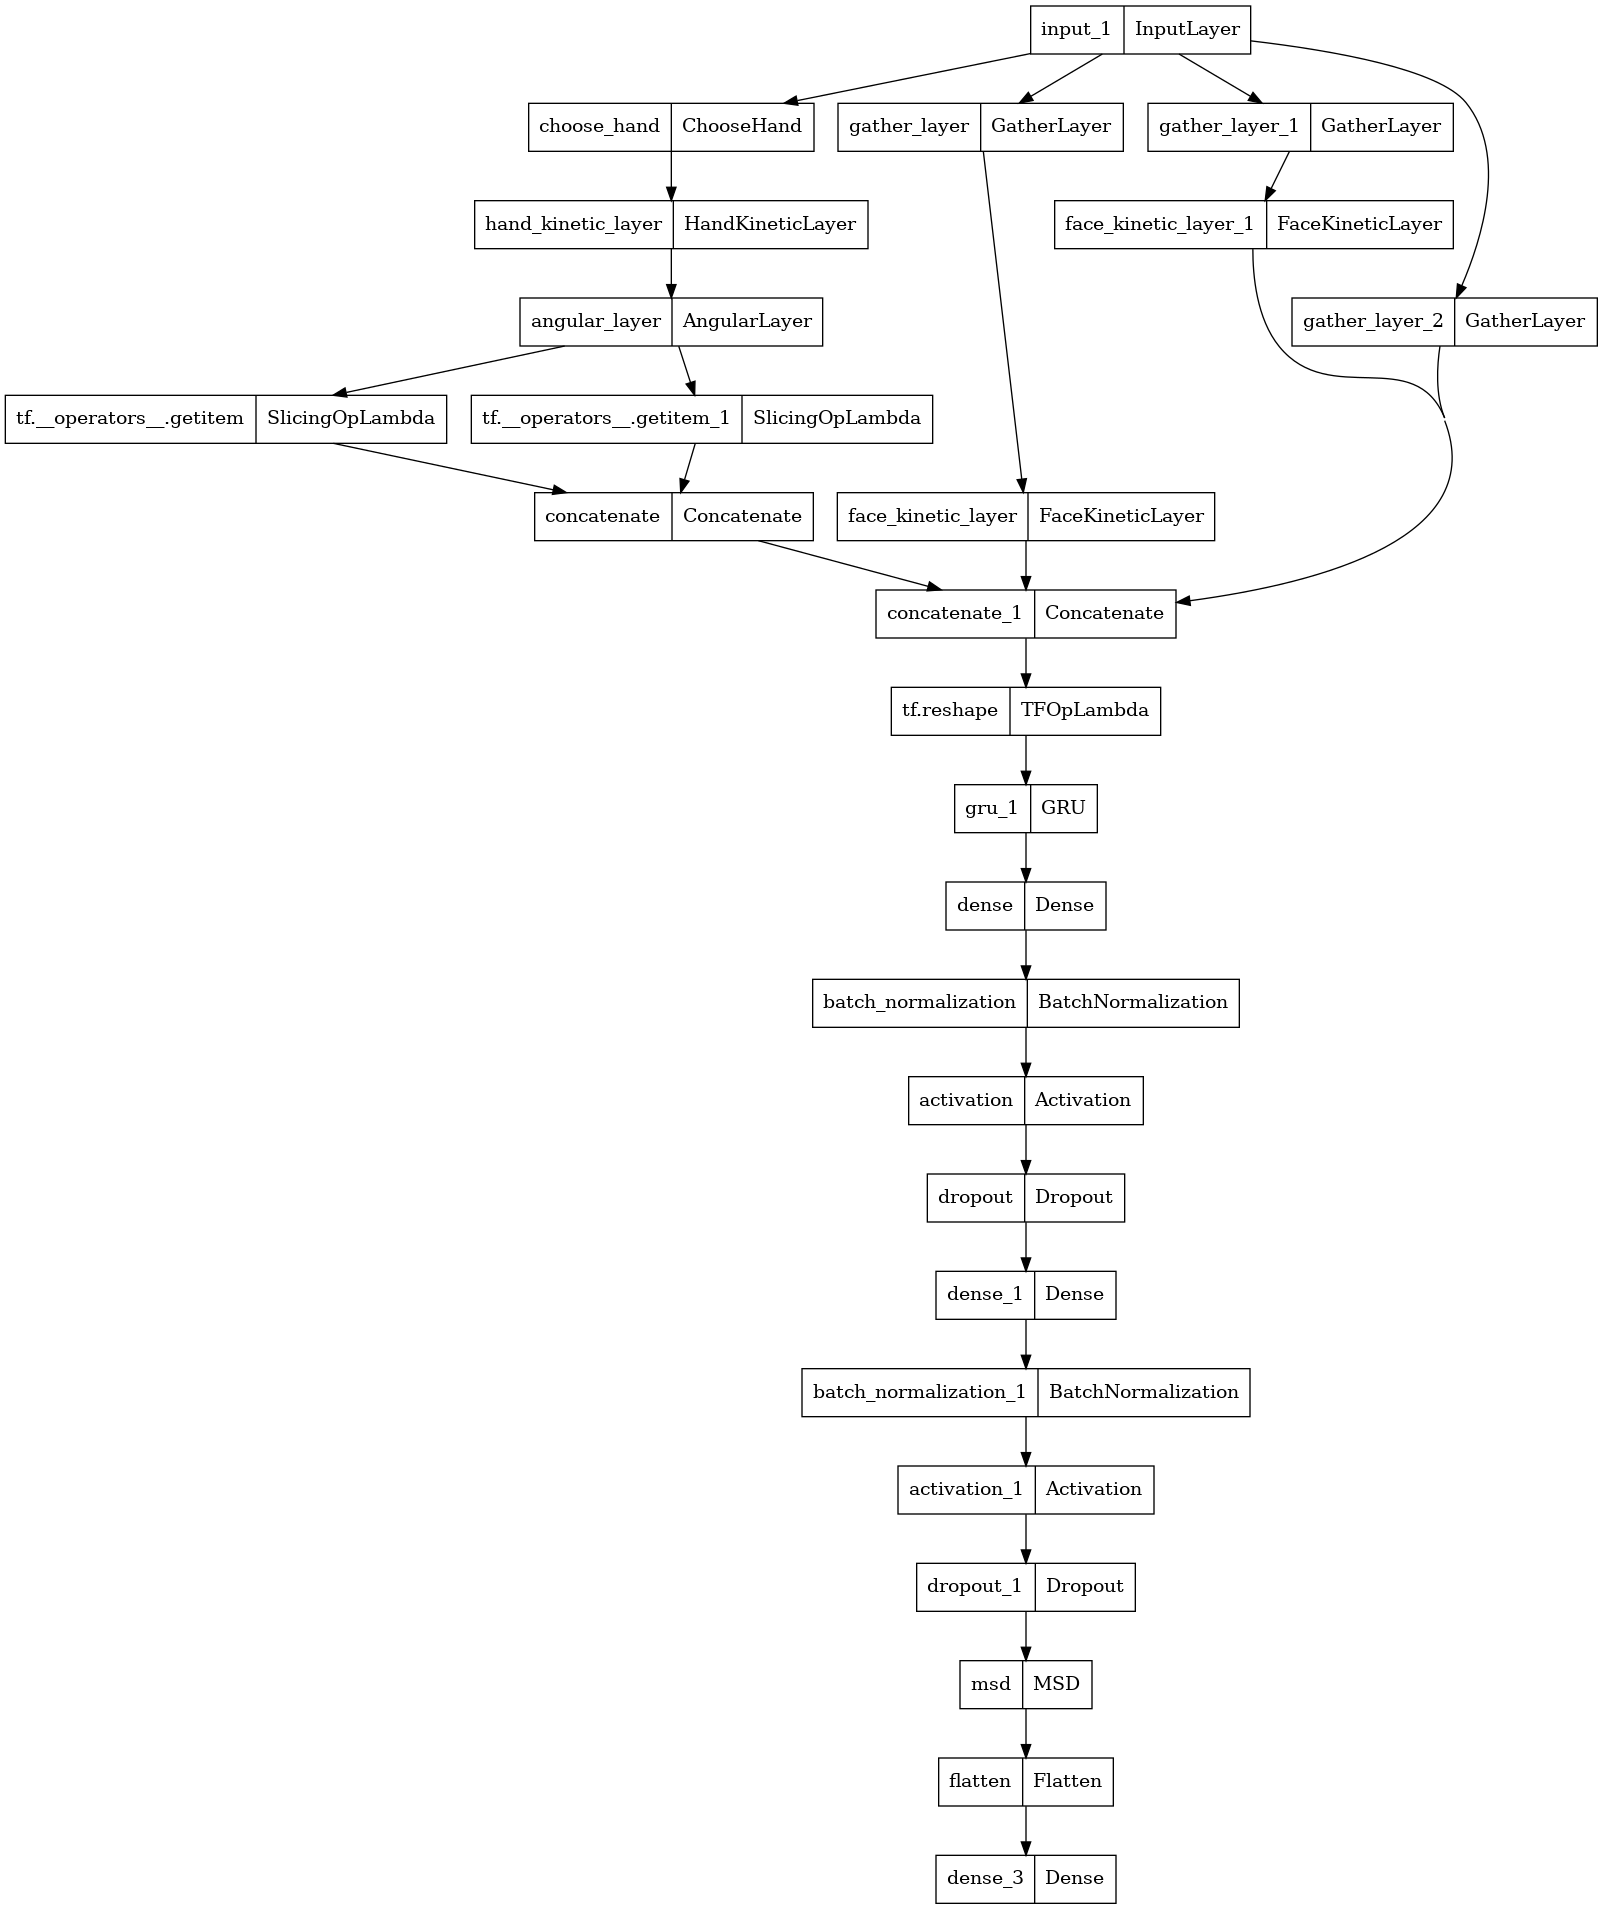

In [8]:
import keras.backend as K

K.clear_session()
model1 = build_model()
model1.summary()
tf.keras.utils.plot_model(model1)

## Train Model

In [9]:
file_name = "model1"
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            file_name, 
            save_best_only=True, 
            restore_best_weights=True, 
            monitor="val_accuracy",
            mode="max"
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            mode="max",
            patience=5
        ),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1)
    ]

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.batch(batch_size=CFG.batch_size, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_dataset = val_dataset.batch(batch_size=CFG.batch_size, drop_remainder=True)

model1.fit(train_dataset, epochs=70, validation_data=val_dataset, batch_size=CFG.batch_size, callbacks=callbacks)

Epoch 1/70
166/166 [==============================] - 162s 528ms/step - loss: 4.4715 - sparse_top_k_categorical_accuracy: 0.2607 - acc: 0.0913 - val_loss: 3.7939 - val_sparse_top_k_categorical_accuracy: 0.4796 - val_acc: 0.2123 - lr: 3.3300e-04
Epoch 2/70
166/166 [==============================] - 43s 259ms/step - loss: 3.5102 - sparse_top_k_categorical_accuracy: 0.4796 - acc: 0.1996 - val_loss: 3.0422 - val_sparse_top_k_categorical_accuracy: 0.5847 - val_acc: 0.2882 - lr: 3.3300e-04
Epoch 3/70
166/166 [==============================] - 43s 259ms/step - loss: 3.2087 - sparse_top_k_categorical_accuracy: 0.5525 - acc: 0.2483 - val_loss: 2.8039 - val_sparse_top_k_categorical_accuracy: 0.6360 - val_acc: 0.3238 - lr: 3.3300e-04
Epoch 4/70
166/166 [==============================] - 43s 262ms/step - loss: 3.0291 - sparse_top_k_categorical_accuracy: 0.5902 - acc: 0.2811 - val_loss: 2.6573 - val_sparse_top_k_categorical_accuracy: 0.6707 - val_acc: 0.3513 - lr: 3.3300e-04
Epoch 5/70
166/166 [===

## Prepare Submission

In [10]:
class PrepInputs(tf.keras.layers.Layer):
    def __init__(self, face_idx_range=(0, 468), lh_idx_range=(468, 489), 
                 pose_idx_range=(489, 522), rh_idx_range=(522, 543)):
        super(PrepInputs, self).__init__()
        self.idx_ranges = [face_idx_range, lh_idx_range, pose_idx_range, rh_idx_range]
        self.flat_feat_lens = [3*(_range[1]-_range[0]) for _range in self.idx_ranges]
    
    def call(self, x_in):
        xs = [x_in[:, _range[0]:_range[1], :] for _range in self.idx_ranges]
        xs = [tf.reshape(_x, (-1, flat_feat_len)) for _x, flat_feat_len in zip(xs, self.flat_feat_lens)]
        
        xs[1:] = [
            tf.boolean_mask(_x, tf.reduce_all(tf.logical_not(tf.math.is_nan(_x)), axis=1), axis=0)
            for _x in xs[1:]
        ]
        
        x_means = [tf.math.reduce_mean(_x, axis=0) for _x in xs]
        x_stds  = [tf.math.reduce_std(_x,  axis=0) for _x in xs]
        
        x_out = tf.concat([*x_means, *x_stds], axis=0)
        x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
        return tf.expand_dims(x_out, axis=0)

In [11]:
import tensorflow as tf

class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, islr_model):
        """
        Initializes the TFLiteModel with the specified preprocessing model and ISLR model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = PrepInputs()
        self.islr_model = islr_model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs = self.islr_model(x)[0, :]

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

In [12]:
tflite_keras_model = TFLiteModel(islr_model=model1)

saved_model_dir = '/kaggle/working/asl_model'
tf.saved_model.save(tflite_keras_model, saved_model_dir)
inf_model = tf.saved_model.load(saved_model_dir)

demo_output = tflite_keras_model(load_relevant_data_subset(CFG.data_dir + train_data.path[0]))["outputs"]
decoder(np.argmax(demo_output.numpy(), axis=-1))

'boy'

In [13]:
keras_model_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = keras_model_converter.convert()

with open('/kaggle/working/asl_model/model.tflite', 'wb') as f:
    f.write(tflite_model)
!zip submission.zip /kaggle/working/asl_model/model.tflite

  adding: kaggle/working/asl_model/model.tflite (deflated 11%)


In [14]:
!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/input/asl-sign-model/asl_model/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=load_relevant_data_subset(CFG.data_dir + train_data.path[0]))
sign = np.argmax(output["outputs"])

print("PREDICTION : ", decoder(sign))
print("ACTUAL   : ", train_data.sign[0])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.3 MB/s eta 0:00:00
PREDICTION :  blow
ACTUAL   :  blow


## Evaluate Model Performance: Heatmap

In [15]:
# y_pred = []
# y_true = []
# for i in tqdm(range(round(len(train_data)*0.75),len(train_data))):
#     output = prediction_fn(inputs=load_relevant_data_subset(CFG.data_dir + train_data.path[i]))
#     sign = np.argmax(output["outputs"])
#     y_pred.append(decoder(sign))
#     y_true.append(train_data.sign[i])
# mat = confusion_matrix(y_true, y_pred)
# fig = px.imshow(mat, text_auto=True)
# fig.show()